In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import unicodedata
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose

formatter = FuncFormatter(lambda x, _: f'${int(x):,}')

# [Fundación Potenciar Solidario](https://potenciarsolidario.org/)
En el siguiente trabajo se realizará una limpieza a la base de datos proporcionada por la Fundación Potenciar Solidario. Dicha base de datos se divide en dos grandes partes: una tabla que representa las donaciones recibidas por la Fundación (ingresos), y otra tabla que administra las transacciones hacia proveedores (gastos). Finalizada la limpieza, se analizarán diferentes aspectos de los datos para luego realizar un informe sobre ingresos y egresos de la Fundación, que incluirá diferentes tipos de gráficos y KPI's.
(Los datos proporcionados no son reales, se trata de una simulación para casos prácticos).

* Al tratarse de transacciones, para los valores duplicados se tuvo en cuenta el número de donante/proveedor y la fecha. Entonces, si dos o más filas tienen el mismo dato en las columnas 'fecha' (o 'alta' en el caso de los donantes) y 'numero', la solución hubiera sido juntar las filas y sumar los importes. Como no fue el caso, no se realizaron cambios de ese tipo.
* Los valores nulos (excepto fechas de baja) se llenaron con valores por default. Por ejemplo, ciertos campos de la columna "ciudad" de la tabla de Donantes se completaron teniendo en cuenta la columna de "país".

#### Definición de dataframes:

In [2]:
data_donantes = pd.read_csv('data/original/donantes.csv')
donantes_temp = pd.DataFrame(data_donantes)

data_proveedores = pd.read_csv('data/original/proveedores.csv')
proveedores_temp = pd.DataFrame(data_proveedores)

#### Eliminación de acentos:

In [3]:
def quitar_acentos(texto):
    if isinstance(texto, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', texto)
            if unicodedata.category(c) != 'Mn'
        )
    return texto

In [4]:
donantes = donantes_temp.map(quitar_acentos)
donantes.columns = [quitar_acentos(col).lower() for col in donantes.columns]

proveedores = proveedores_temp.map(quitar_acentos)
proveedores.columns = [quitar_acentos(col).lower() for col in proveedores.columns]

#### Corrección de tipos de datos:

In [5]:
donantes['alta'] = pd.to_datetime(donantes['alta'], format='%d/%m/%Y')
donantes['baja'] = pd.to_datetime(donantes['baja'], format='%d/%m/%Y')
donantes['importe'] = donantes['importe'].replace({'\\$': '', '\\.': ''}, regex = True)
donantes['importe'] = donantes['importe'].str.replace(',', '.')
donantes['importe'] = donantes['importe'].astype(float)
donantes['activo'] = donantes['activo'].map({'SI': True, 'NO': False})
donantes['activo'] = donantes['activo'].astype(bool)

proveedores['fecha'] = pd.to_datetime(proveedores['fecha'], format='%d/%m/%Y')
proveedores['importe'] = proveedores['importe'].replace({'\\$': '', '\\.': ''}, regex = True)
proveedores['importe'] = proveedores['importe'].str.replace(',', '.')
proveedores['importe'] = proveedores['importe'].astype(float)

#### Manejo de valores nulos y correcciones ortográficas:

In [6]:
# Diccionario para colocar por default una ciudad de cada país, donde el dato de 'ciudad' sea nulo:
pais_ciudad = {
    'Argentina': 'Buenos Aires',
    'Brasil': 'Rio de Janeiro',
    'Chile': 'Santiago de Chile',
    'Colombia': 'Bogota',
    'Paraguay': 'Asuncion',
    'Uruguay': 'Montevideo',
    'Peru': 'Lima',
    'Venezuela': 'Caracas',
    'Bolivia': 'La Paz'
}

In [7]:
# Limpieza de Donantes:
donantes.fillna({'descripcion': 'varios'}, inplace = True)
donantes.fillna({'observaciones': 'Observacion 105'}, inplace = True)
donantes['razon social'] = donantes['razon social'].bfill()
donantes['contacto'] = donantes['contacto'].bfill()
donantes['cargo'] = donantes['cargo'].replace(['Cordinador', 'ccoordinador', 'COORDINADOR'], 'Coordinador')
donantes['razon social'] = donantes['razon social'].replace(['SA', 'S.A', '-'], 'S.A.')
donantes['razon social'] = donantes['razon social'].replace(['SRL', 'S.R.L'], 'S.R.L.')
donantes['razon social'] = donantes['razon social'].replace('SAS', 'S.A.S.')
donantes['tipo'] = donantes['tipo'].replace('Campana', 'Campaña')

for pais, ciudad in pais_ciudad.items():
    donantes.loc[donantes['pais'] == pais, 'ciudad'] = donantes.loc[donantes['pais'] == pais, 'ciudad'].fillna(ciudad)

# Limpieza de Proveedores:
proveedores = proveedores.dropna(subset = ['cuit'])
proveedores['observaciones'] = proveedores['observaciones'].bfill()
proveedores['tipo de contribuyente'] = proveedores['tipo de contribuyente'].replace(['RESPONSABLE INSCR/ITO', 'RESPONSABILE INSCRIPTO', 'RESPONSAB/LE INSCRIPTO', 'Responsable Inscripto'], 'RESPONSABLE INSCRIPTO')
proveedores['tipo de contribuyente'] = proveedores['tipo de contribuyente'].replace('Monotributista', 'MONOTRIBUTISTA')
proveedores['razon social'] = proveedores['razon social'].replace('Cooperativa', 'Coop.')
proveedores['tipo de contribuyente'] = proveedores['tipo de contribuyente'].str.title()

# Donantes

#### Comprobación de valores nulos y duplicados; solo la columna 'baja' (fecha de baja) puede tener valores nulos, ya que muchos donantes aún se encuentran en estado activo:

In [8]:
print(f"Comprobacion de valores nulos:\n {donantes.isnull().sum()}")
print(f"\nComprobacion de valores duplicados: {donantes.duplicated().sum()}")

Comprobacion de valores nulos:
 numero                     0
nombre                     0
tipo                       0
contacto                   0
cargo                      0
correo electronico         0
telefono                   0
ciudad                     0
pais                       0
observaciones              0
razon social               0
tipo de contribuyente      0
cuit                       0
alta                       0
baja                     411
activo                     0
frecuencia                 0
importe                    0
nro de cuenta              0
nombre de cuenta           0
descripcion                0
dtype: int64

Comprobacion de valores duplicados: 0


#### Suma de importes totales por frecuencia (activos, no activos y total):

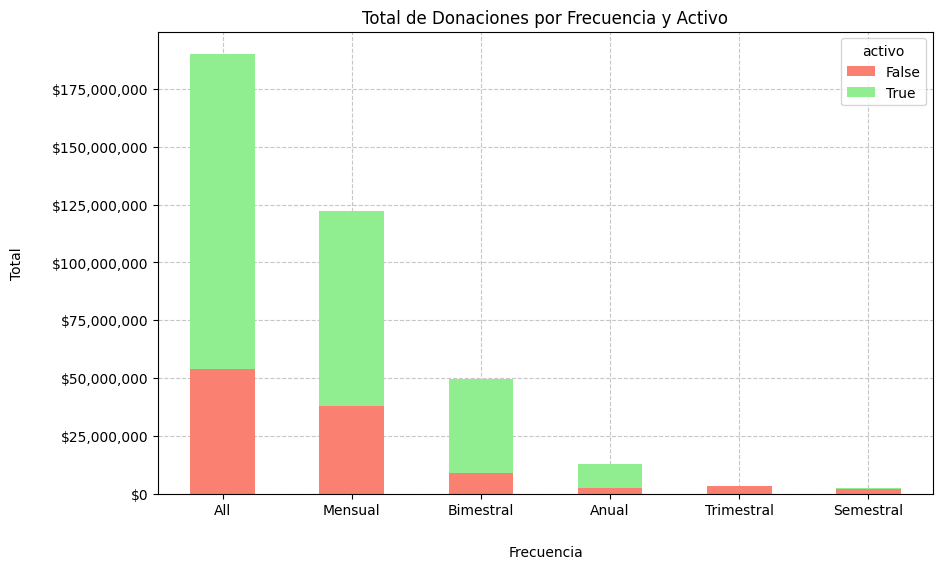

In [9]:
donantes_importes_totales = pd.crosstab(donantes['frecuencia'], donantes['activo'], values = donantes['importe'], aggfunc = 'sum', margins = True)
donantes_importes_totales = donantes_importes_totales.fillna(0)
donantes_importes_totales = donantes_importes_totales.sort_values(by = 'All', ascending = False)

donantes_importes_totales = donantes_importes_totales.drop(columns = 'All')

ax_frec = donantes_importes_totales.plot(kind = 'bar', figsize = (10, 6), stacked = True, color=['salmon', 'lightgreen'])
ax_frec.yaxis.set_major_formatter(formatter)
plt.title('Total de Donaciones por Frecuencia y Activo')
plt.xlabel('Frecuencia', labelpad = 20)
plt.ylabel('Total', labelpad = 20)
plt.xticks(rotation = 0)
ax_frec.grid(True,  linestyle = '--', alpha = 0.7)
ax_frec.set_axisbelow(True)
plt.show()

#### Total de importe por año (Activos):

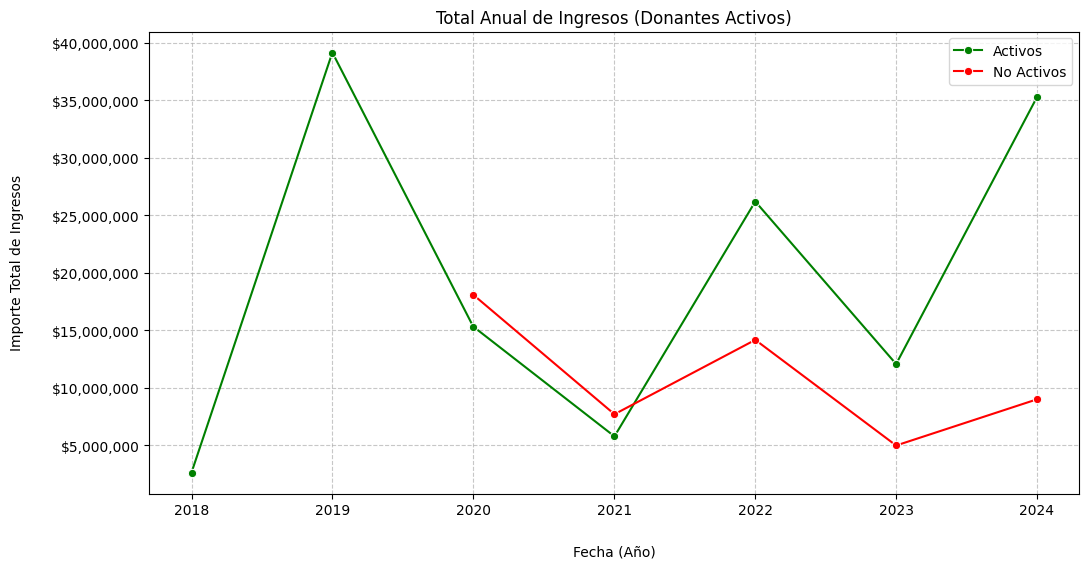

In [10]:
# Agrupando los datos en donantes solo activos:
activos = donantes[donantes['activo'] == True]
temp_activos = activos.groupby('alta')['importe'].sum()
activos_importe_anual = temp_activos.groupby(pd.Grouper(freq = 'YE')).sum()
activos_importe_anual = activos_importe_anual.reset_index()
activos_importe_anual['alta'] = activos_importe_anual['alta'].dt.to_period('Y').dt.start_time

# Agrupando los datos en donantes solo inactivos:
inactivos = donantes[donantes['activo'] == False]
temp_inactivos = inactivos.groupby('alta')['importe'].sum()
inactivos_importe_anual = temp_inactivos.groupby(pd.Grouper(freq = 'YE')).sum()
inactivos_importe_anual = inactivos_importe_anual.reset_index()
inactivos_importe_anual['alta'] = inactivos_importe_anual['alta'].dt.to_period('Y').dt.start_time

plt.figure(figsize = (12, 6))

# Activos:
ax_activos_anual = sns.lineplot(x = 'alta', y = 'importe', data = activos_importe_anual, marker = 'o', color = 'green', label = 'Activos')
ax_activos_anual.yaxis.set_major_formatter(formatter)

# Inactivos:
sns.lineplot(x = 'alta', y = 'importe', data = inactivos_importe_anual, marker = 'o', color = 'red', label = 'No Activos')

# Grafico:
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.title('Total Anual de Ingresos (Donantes Activos)')
plt.xlabel('Fecha (Año)', labelpad = 20)
plt.ylabel('Importe Total de Ingresos', labelpad = 20)
plt.legend(loc = 'best')
plt.show()

#### Distribución de Donaciones (sólo activos):

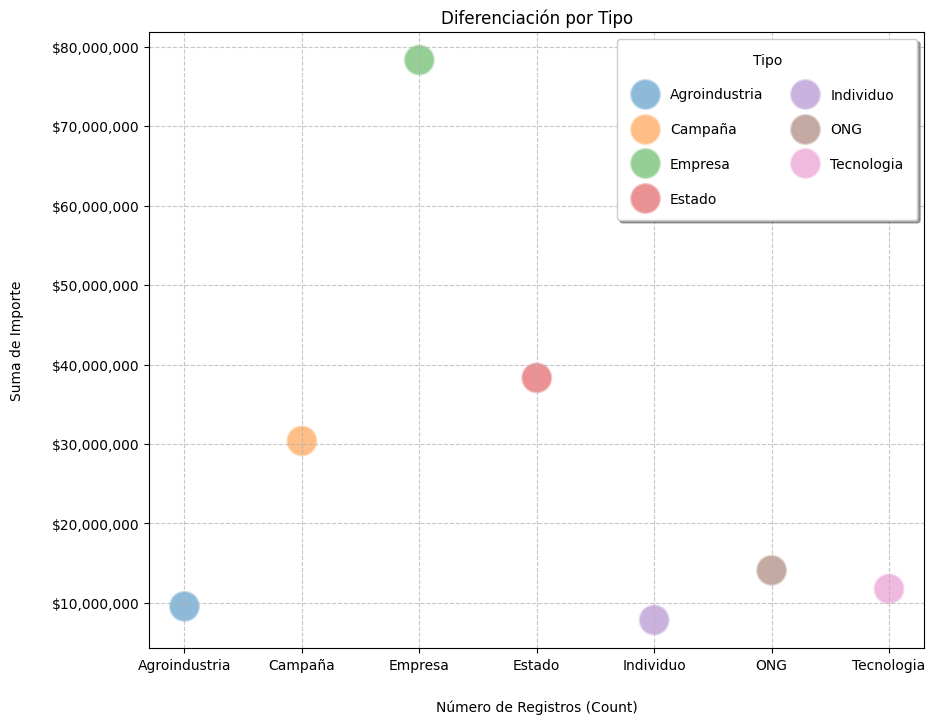

In [11]:
donaciones_tipo = donantes.groupby('tipo')['importe'].sum()
donaciones_tipo = donaciones_tipo.reset_index()

plt.figure(figsize = (10, 8))
ax_agg = sns.scatterplot(x = 'tipo', y = 'importe', s = 500, data = donaciones_tipo, hue = 'tipo', palette = 'tab10', alpha = 0.5)
plt.xlabel('Número de Registros (Count)', labelpad = 20)
plt.ylabel('Suma de Importe', labelpad = 20)
plt.title('Diferenciación por Tipo')
plt.legend(title = "Tipo", loc = 'best', labelspacing = 1.5, ncol = 2, shadow = True, borderpad = 1.0)
plt.grid(True, linestyle = '--', alpha = 0.7)
ax_agg.yaxis.set_major_formatter(formatter)
plt.show()

#### Utilizando el cálculo para encontrar los rangos intercuartílicos, se encontró un valor atípico (outlier) en la columna de importe de Donantes. Para este caso, se decidió reemplazar el valor por un número aproximado a la media general de la columna.

In [12]:
Q1 = donantes['importe'].quantile(0.25)
Q3 = donantes['importe'].quantile(0.75)
IQR = Q3 - Q1
umbral_bajo = Q1 - 1.5 * IQR
umbral_alto = Q3 + 1.5 * IQR

outliers = donantes[(donantes['importe'] < umbral_bajo) | (donantes['importe'] > umbral_alto)]
display(outliers)

,numero,nombre,tipo,contacto,cargo,correo electronico,telefono,ciudad,pais,observaciones,...,tipo de contribuyente,cuit,alta,baja,activo,frecuencia,importe,nro de cuenta,nombre de cuenta,descripcion
374,D00123,Merendero Solidario,ONG,-,-,solidario@mail.com,+591 5550-9225,La Paz,Bolivia,Observacion D,...,Monotributista,24-72582356-8,2021-01-02,NaT,True,Mensual,1121873.0,405100,Ingresos Servicios,"Servicios Sociales, Asistencia Tecnica, Educac..."


In [13]:
media_importe = donantes['importe'].mean()
media_importe_sin_decimales = media_importe // 1
donantes['importe'] = donantes['importe'].apply(lambda x: media_importe_sin_decimales if x < umbral_bajo or x > umbral_alto else x)

# Proveedores

#### Comprobación de valores nulos y duplicados:

In [14]:
print(f"Comprobacion de valores nulos:\n {proveedores.isnull().sum()}")
print(f"\nComprobacion de valores duplicados: {proveedores.duplicated().sum()}")

Comprobacion de valores nulos:
 numero proveedor         0
nombre proveedor         0
cuit                     0
categoria proveedor      0
tipo de contribuyente    0
observaciones            0
contacto                 0
correo electronico       0
telefono                 0
razon social             0
importe                  0
fecha                    0
nro_cuenta               0
ciudad                   0
pais                     0
nombre de cuenta         0
descripcion              0
mes                      0
dtype: int64

Comprobacion de valores duplicados: 0


#### Egresos totales por año:

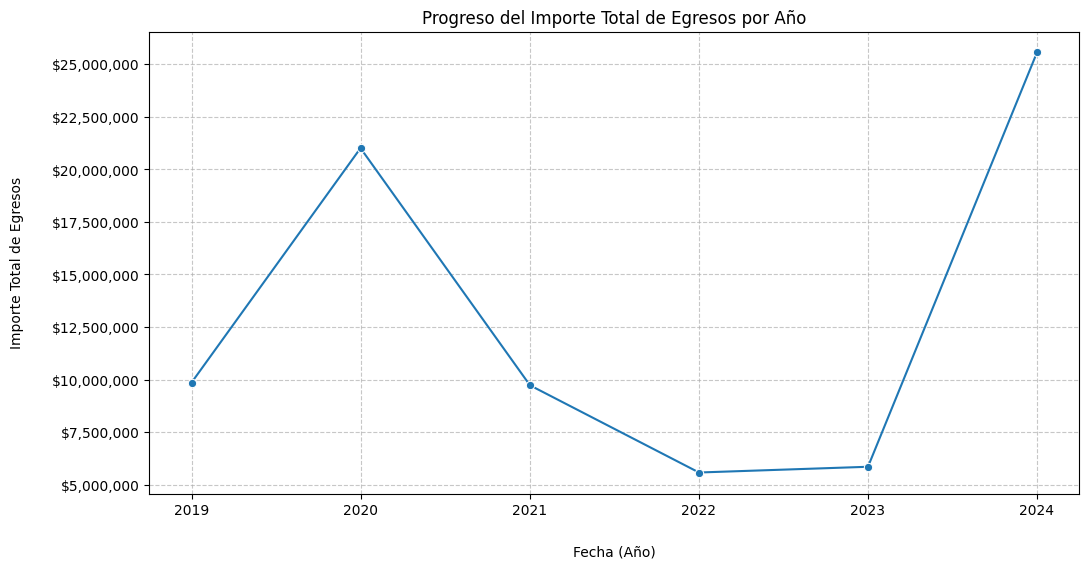

In [15]:
gasto_anual = proveedores.groupby(pd.Grouper(key = 'fecha', freq = 'YE'))['importe'].sum()
gasto_anual = gasto_anual.reset_index()
gasto_anual['fecha'] = gasto_anual['fecha'].dt.to_period('Y').dt.start_time

plt.figure(figsize = (12, 6))
ax_gasto_anual = sns.lineplot(x = 'fecha', y = 'importe', data = gasto_anual, marker = 'o')
ax_gasto_anual.yaxis.set_major_formatter(formatter)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.title('Progreso del Importe Total de Egresos por Año')
plt.xlabel('Fecha (Año)', labelpad = 20)
plt.ylabel('Importe Total de Egresos', labelpad = 20)
plt.show()

#### Promedio mensual de gastos:

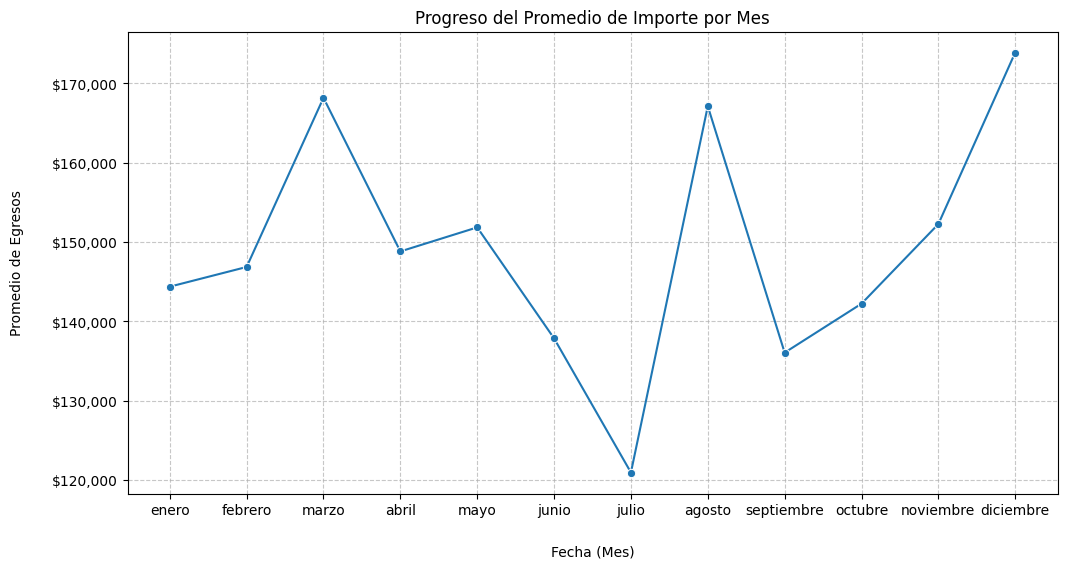

In [16]:
# Categoria ordenada para representar el orden de los meses de forma correcta:
meses_ordenados = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
proveedores['mes'] = pd.Categorical(proveedores['mes'], categories = meses_ordenados, ordered = True)

promedio_mensual = proveedores.groupby('mes', observed = True)['importe'].mean()
promedio_mensual = promedio_mensual.reset_index()

plt.figure(figsize = (12, 6))
ax_promedio_mensual = sns.lineplot(x = 'mes', y = 'importe', data = promedio_mensual, marker = 'o')
ax_promedio_mensual.yaxis.set_major_formatter(formatter)
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.title('Progreso del Promedio de Importe por Mes')
plt.xlabel('Fecha (Mes)', labelpad = 20)
plt.ylabel('Promedio de Egresos', labelpad = 20)
plt.show()

#### Importe total de e anuales por categoría

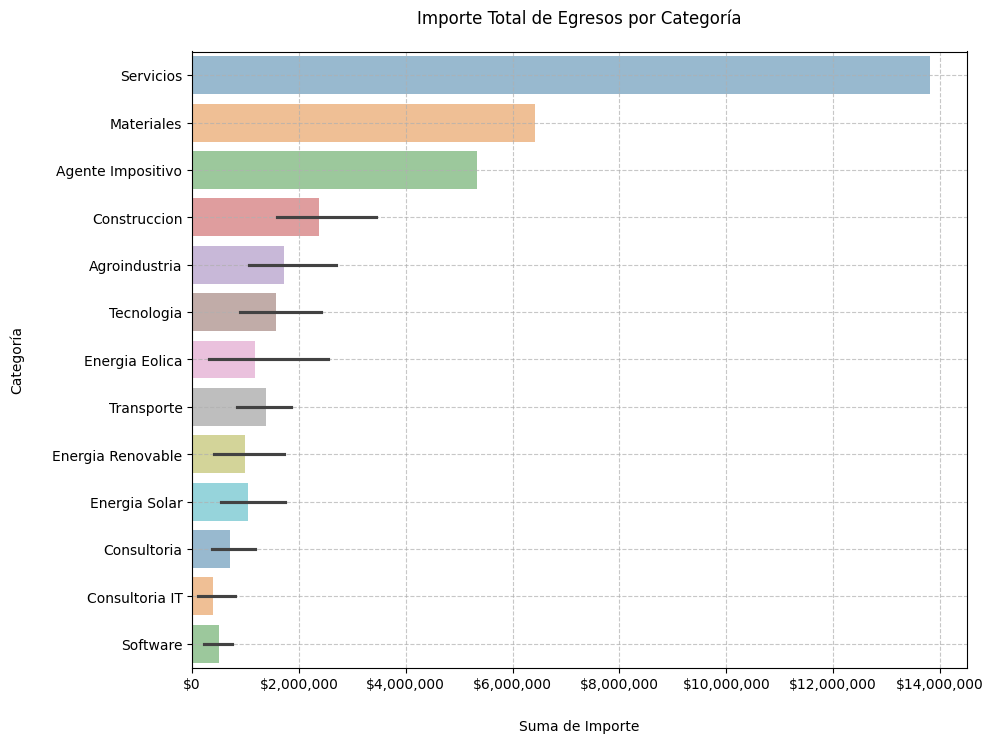

In [17]:
gastos_categoria = proveedores.groupby([pd.Grouper(key = 'fecha', freq = 'YE'), 'categoria proveedor'])['importe'].sum()
gastos_categoria = gastos_categoria.reset_index()
gastos_categoria = gastos_categoria.sort_values(ascending = False, by = 'importe')

plt.figure(figsize = (10, 8))
ax_gastos = sns.barplot(x = 'importe', y = 'categoria proveedor', data = gastos_categoria, palette = 'tab10', alpha = 0.5, hue = 'categoria proveedor')
plt.xlabel('Suma de Importe', labelpad = 20)
plt.ylabel('Categoría', labelpad = 20)
plt.title('Importe Total de Egresos por Categoría', pad=20)
plt.grid(True, linestyle = '--', alpha = 0.7)
ax_gastos.xaxis.set_major_formatter(formatter)
plt.show()

#### Correlación entre las diferentes categorías de gastos:

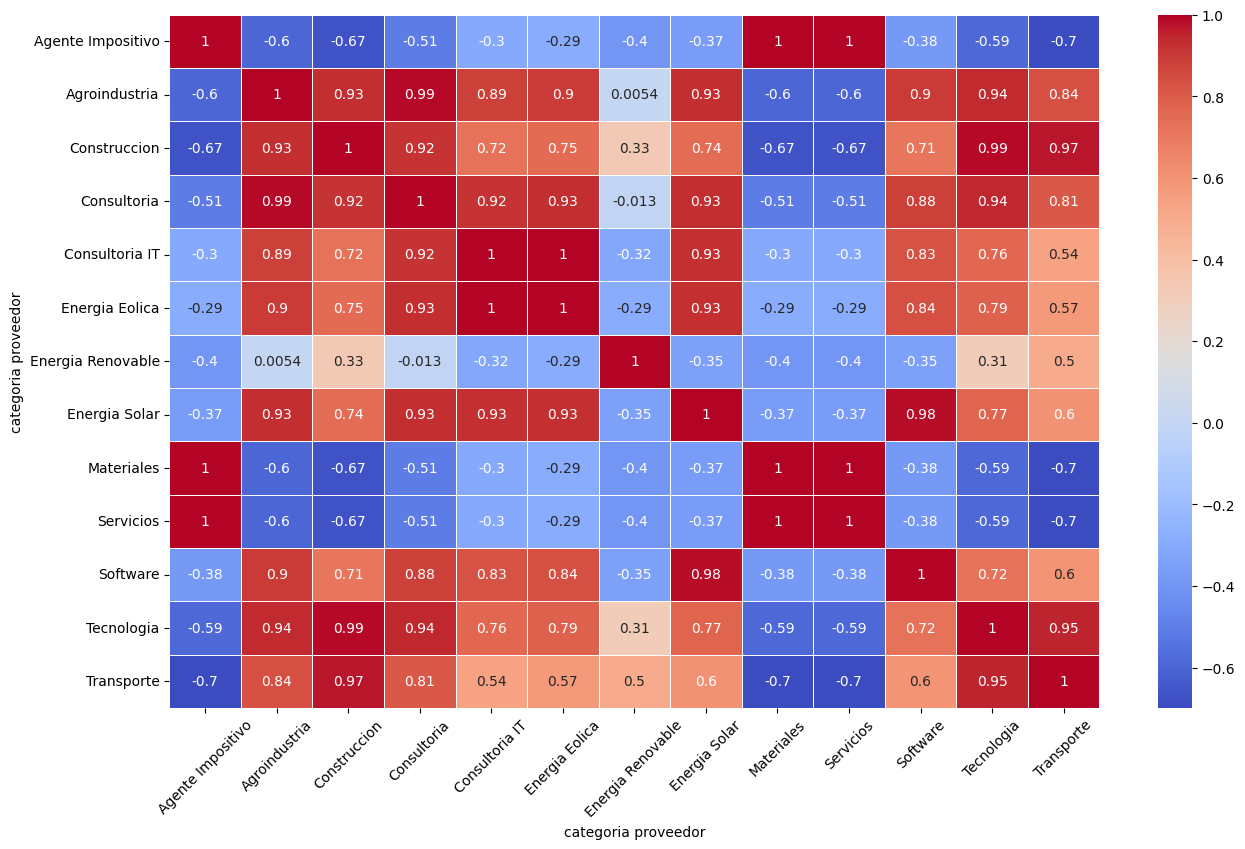

In [18]:
proveedores['año'] = proveedores['fecha'].dt.year
pivot_categorias = proveedores.pivot_table(index = 'año', columns = 'categoria proveedor', values = 'importe', aggfunc = 'sum').fillna(0)
correlacion_categorias = pivot_categorias.corr()

plt.figure(figsize = (15, 9))
sns.heatmap(correlacion_categorias, annot = True, cmap = 'coolwarm', linewidths = 0.5)
plt.xticks(rotation = 45)
plt.show()